### Utility function

In [1]:
import matplotlib.pyplot as plt


def display(img, size=2):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

### Data preprocessing

In [2]:
import torch
from torch.utils.data import Dataset, random_split
from mnist import MNIST


class MnistDataset(Dataset):
    def __init__(self, train: bool):
        self.train = train
        mndata = MNIST("./data")

        self.images, self.labels = None, None

        if train:
            self.images, self.labels = mndata.load_training()
        else:
            self.images, self.labels = mndata.load_testing()

        self.labels = torch.tensor(self.labels, dtype=torch.uint8)
        self.images = torch.tensor(self.images, dtype=torch.float32)

        self.images = self.images / torch.max(self.images)
        self.images = torch.reshape(self.images, (-1, 28, 28))
        self.images = torch.unsqueeze(self.images, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [3]:
dataset_train_val = MnistDataset(train=True)
dataset_test = MnistDataset(train=False)

dataset_train, dataset_val = random_split(dataset_train_val, [54000, 6000])

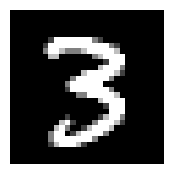

In [4]:
display(dataset_train[0][0][0])

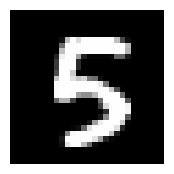

In [5]:
display(dataset_train[42][0][0])

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=60, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=100, shuffle=True)

### Build NN

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [23]:
from torch import nn
import torch.optim as optim


class MnistClassifier(nn.Module):
    def __init__(self, conv1_layers: int = 32, conv2_layers=64):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, conv1_layers, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(conv1_layers, conv2_layers, 3),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(conv2_layers * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=0),
        )

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.1)

    def forward(self, x):
        logits = self.seq(x)
        return logits

    def optimize_paramters(self, inputs, labels):
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self(inputs)
        loss = self.loss(outputs, labels)
        loss.backward()
        self.optimizer.step()

        return loss

### Training

In [24]:
import time


net = MnistClassifier()

start_time = time.time()

for epoch in range(30):  # loop over the dataset multiple times
    print(f"Epoch: {epoch}")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        loss = net.optimize_paramters(inputs, labels)

        # Gather data and report
        running_loss += loss.item()

    print(
        f"[{epoch + 1}] training loss: {running_loss / (len(train_dataloader) * train_dataloader.batch_size):.5f}"
    )
    running_loss = 0.0

    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = net.loss(outputs, labels)

            val_loss += loss.item()

        print(
            f"[{epoch + 1}] validation loss: {val_loss / (len(val_dataloader) * val_dataloader.batch_size):.5f}"
        )
        val_loss = 0.0

end_time = time.time()

print(f"Finished Training in {end_time - start_time:.1f}s")

Epoch: 0
[1] training loss: 0.03753
[1] validation loss: 0.02186
Epoch: 1
[2] training loss: 0.03371
[2] validation loss: 0.01732
Epoch: 2
[3] training loss: 0.02229
[3] validation loss: 0.00963
Epoch: 3
[4] training loss: 0.01387
[4] validation loss: 0.00681
Epoch: 4
[5] training loss: 0.01092
[5] validation loss: 0.00545
Epoch: 5
[6] training loss: 0.00920
[6] validation loss: 0.00465
Epoch: 6
[7] training loss: 0.00816
[7] validation loss: 0.00428
Epoch: 7
[8] training loss: 0.00743
[8] validation loss: 0.00380
Epoch: 8
[9] training loss: 0.00686
[9] validation loss: 0.00356
Epoch: 9
[10] training loss: 0.00636
[10] validation loss: 0.00325
Epoch: 10
[11] training loss: 0.00602
[11] validation loss: 0.00298
Epoch: 11
[12] training loss: 0.00561
[12] validation loss: 0.00286
Epoch: 12
[13] training loss: 0.00534
[13] validation loss: 0.00264
Epoch: 13
[14] training loss: 0.00503
[14] validation loss: 0.00257
Epoch: 14
[15] training loss: 0.00475
[15] validation loss: 0.00237
Epoch: 1

In [30]:
correct_pred = {classname: 0 for classname in map(str, range(10))}
total_pred = {classname: 0 for classname in map(str, range(10))}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        predictions = torch.argmax(outputs, dim=1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[str(label.item())] += 1
            total_pred[str(label.item())] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: 0     is 87.7 %
Accuracy for class: 1     is 78.8 %
Accuracy for class: 2     is 78.4 %
Accuracy for class: 3     is 74.6 %
Accuracy for class: 4     is 80.3 %
Accuracy for class: 5     is 75.1 %
Accuracy for class: 6     is 80.6 %
Accuracy for class: 7     is 79.4 %
Accuracy for class: 8     is 77.1 %
Accuracy for class: 9     is 72.8 %


tensor([8, 4, 8, 3, 5, 7, 6, 1, 9, 5])
tensor([8, 4, 8, 5, 5, 7, 6, 7, 9, 5], dtype=torch.uint8)


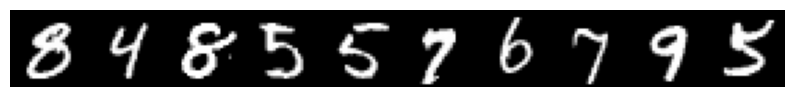

tensor([5, 8, 3, 6, 0, 0, 6, 8, 2, 7])
tensor([5, 3, 3, 8, 0, 0, 0, 3, 7, 7], dtype=torch.uint8)


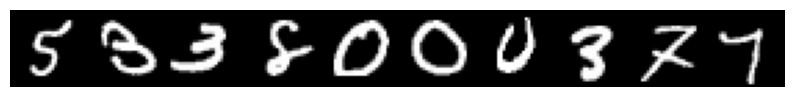

tensor([2, 1, 9, 7, 0, 5, 3, 0, 8, 6])
tensor([8, 8, 9, 0, 0, 5, 3, 0, 8, 6], dtype=torch.uint8)


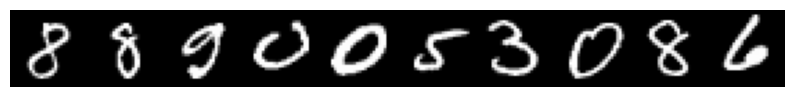

tensor([1, 0, 9, 1, 3, 2, 4, 6, 8, 1])
tensor([1, 0, 9, 1, 3, 0, 4, 6, 8, 1], dtype=torch.uint8)


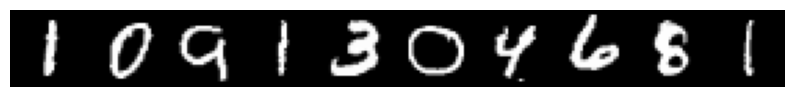

tensor([7, 9, 3, 7, 1, 2, 8, 5, 4, 7])
tensor([7, 9, 7, 7, 1, 7, 8, 5, 5, 7], dtype=torch.uint8)


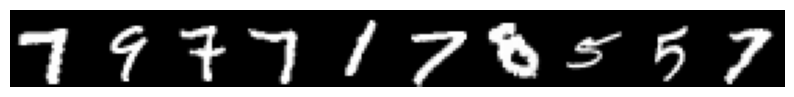

tensor([1, 1, 0, 8, 6, 2, 3, 1, 5, 9])
tensor([1, 1, 6, 3, 6, 2, 3, 1, 1, 9], dtype=torch.uint8)


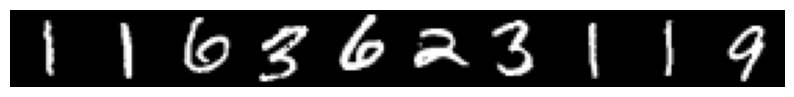

tensor([2, 7, 4, 7, 6, 5, 9, 1, 2, 8])
tensor([2, 7, 4, 7, 6, 5, 9, 1, 2, 5], dtype=torch.uint8)


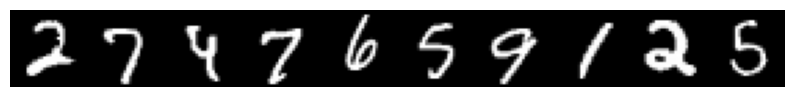

tensor([1, 9, 7, 8, 4, 0, 0, 2, 3, 8])
tensor([1, 9, 7, 8, 9, 0, 0, 2, 7, 8], dtype=torch.uint8)


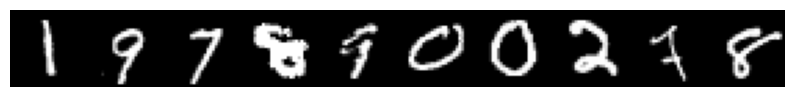

In [31]:
import numpy as np


def result():
    dataiter = iter(test_dataloader)

    image_to_display = None

    for _ in range(8):
        images, labels = next(dataiter)
        output = net(images)
        print(torch.argmax(output, dim=1))
        print(labels)

        images = torch.squeeze(images, dim=1).numpy()

        image_to_display = images[0]

        for i in range(1, len(images)):
            image_to_display = np.hstack((image_to_display, images[i]))

        display(image_to_display, size=10)


with torch.no_grad():
    result()